# BlazingText를 활용한 네이버 영화 리뷰 감성(Sentiment) 이진 분류
*본 노트북 예제는 [DBPedia Ontology Dataset의 텍스트 분류](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/introduction_to_amazon_algorithms/blazingtext_text_classification_dbpedia/blazingtext_text_classification_dbpedia.ipynb) 문서에 기반하여
네이버 영화 리뷰의 텍스트 분류를 수행하는 예제입니다.*

개발자 가이드: https://github.com/awsdocs/amazon-sagemaker-developer-guide/blob/master/doc_source/blazingtext.md

## 개요

텍스트 분류(Text cassification)는 감성 분석(sentiment analysis), 스팸 탐지(spam detection), 해시 태그 예측(hashtag prediction) 등과 같은 다양한 사례들을 해결하는 데 사용될 수 있습니다. BlazingText는 최신 딥러닝 텍스트 분류 알고리즘과 동등한 성능을 달성하면서 멀티 코어 CPU 또는 GPU를 사용하여 몇 분 안에 10억 단어 이상의 모델을 훈련시킬 수 있습니다. BlazingText는 사용자 정의 CUDA 커널을 사용하여 GPU 가속을 활용하도록 FastText 텍스트 분류기를 확장합니다.

본 노트북에서는 네이버 영화 리뷰 데이터의 감성 이진 분류를 BlzaingText로 수행해 보겠습니다. 이 데이터는 총 20만개 리뷰로 구성된 데이터로 영화 리뷰에 대한 텍스트와 레이블(0: 부정, 1: 긍정)으로 구성되어 있습니다.

## Setup

학습 데이터 및 모델 아티팩트(Model Artifact) 저장에 사용될 S3 버킷(bucket) 및 접두사(prefix)는 노트북 인스턴스, 학습 및 호스팅과 같은 리전 내에 있어야 합니다. 버킷을 지정하지 않으면 SageMaker SDK는 동일 리전에서 사전에 정의된 명명 규칙에 따라 기본 버킷을 생성합니다.

데이터에 대한 엑세스 권한을 부여하는 데 사용된 IAM(Identity and Access Management) role ARN(Amazon Resource Name)은 SageMaker Python SDK의 `get_execution_role` 메소드를 사용하여 가져올 수 있습니다.

In [1]:
import sagemaker
from sagemaker import get_execution_role
import boto3
import json

sess = sagemaker.Session()

# This is the role that SageMaker would use to leverage AWS resources (S3, CloudWatch) on your behalf
role = get_execution_role() 
#print(role)

#bucket = sess.default_bucket()
bucket = '[YOUR-BUCKET]'  # Replace with your own bucket name if needed
prefix = 'sagemaker/DEMO-blazingtext-sentiment-analysis' #Replace with the prefix under which you want to store the data if needed

## 데이터 준비

https://github.com/e9t/nsmc/ 에 공개된 네이버 영화 리뷰 학습/검증 데이터를 다운로드합니다.<br>
학습 데이터는 총 15만건이며, 검증 데이터는 총 5만건입니다.

In [2]:
!wget -nc https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt -P ./data/
!wget -nc https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt -P ./data/

--2019-11-06 06:55:17--  https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.248.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.248.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14628807 (14M) [text/plain]
Saving to: ‘./data/ratings_train.txt’

ratings_train.txt   100%[===================>]  13.95M  --.-KB/s    in 0.1s    

2019-11-06 06:55:17 (100 MB/s) - ‘./data/ratings_train.txt’ saved [14628807/14628807]

--2019-11-06 06:55:17--  https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.248.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.248.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4893335 (4.7M) [text/plain]
Saving to: ‘./data/ratings_test.txt’

ratings_test.txt    100%[=======

## EDA (탐색적 데이터 분석; Exploratory Data Analysis)

간단하게 EDA를 수행해 봅니다. 네이버 영화 리뷰 데이터는 정제가 잘 되어 있는 편이지만, 실제 데이터들은 클래스 불균형(class imbalance)한 데이터도 많고 데이터 정제가 필요한 경우가 많기에 EDA를 통해 데이터의 분포, 통계량 등을 확인하는 것이 좋습니다.

먼저 판다스(pandas)로 학습/검증 데이터를 로드해서 데이터를 확인해 보겠습니다. <br>
`id`는 고유 id 이며, `document`는 영화 리뷰 문장, `label`은 긍정/부정 여부입니다. (긍정: 1, 부정: 0)

In [3]:
import pandas as pd
import numpy as np
from wordcloud import WordCloud

train_df = pd.read_csv('./data/ratings_train.txt', header=0, delimiter='\t')
test_df = pd.read_csv('./data/ratings_test.txt', header=0, delimiter='\t')

In [4]:
train_df.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


EDA를 위해 문자 개수 및 단어 개수를 계산합니다.

In [5]:
# character count 계산
train_df['char_cnt'] = train_df['document'].astype(str).apply(len)
test_df['char_cnt'] = test_df['document'].astype(str).apply(len)

# word count 계산
train_df['word_cnt'] = train_df['document'].astype(str).apply(lambda x: len(x.split(' ')))
test_df['word_cnt'] = train_df['document'].astype(str).apply(lambda x: len(x.split(' ')))

In [6]:
train_df.head()

,id,document,label,char_cnt,word_cnt
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0,19,5
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1,33,4
2,10265843,너무재밓었다그래서보는것을추천한다,0,17,1
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0,29,6
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1,61,11


한글 출력을 위한 설정입니다.

In [7]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

font_files = fm.findSystemFonts(fontpaths='/usr/share/fonts/nanum', fontext='ttf')
font_list = fm.createFontList(font_files)
fm.fontManager.ttflist.extend(font_list)

mpl.rcParams['font.family'] = 'NanumGothic'
mpl.rc('axes', unicode_minus=False)
mpl.rcParams['font.size'] = 14

문자 개수와 단어 개수를 확인해 봅니다.

Text(0.5, 0, '문자 개수')

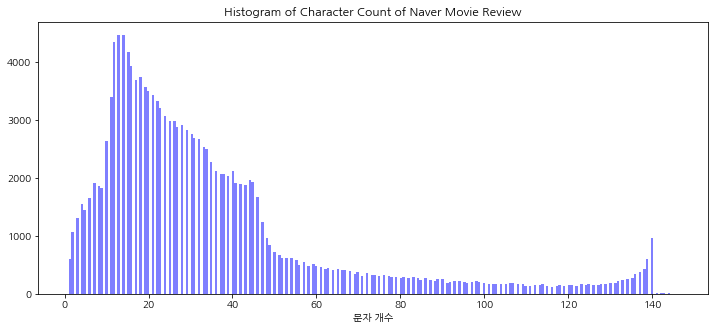

In [8]:
plt.figure(figsize=(12,5))
plt.hist(train_df['char_cnt'], bins=250, alpha=0.5, color='b', label='word')
plt.title('Histogram of Character Count of Naver Movie Review')
plt.xlabel('문자 개수')

Text(0.5, 0, '단어 개수')

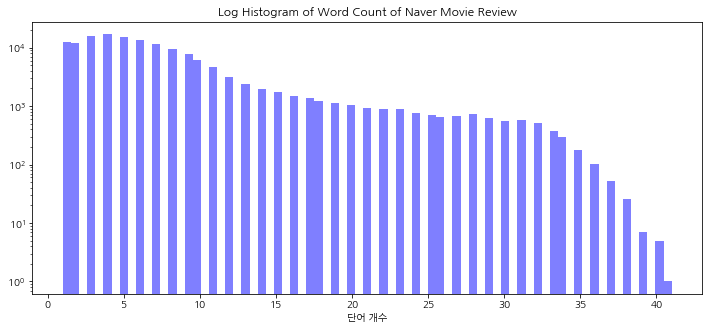

In [9]:
plt.figure(figsize=(12,5))
plt.hist(train_df['word_cnt'], bins=75, alpha=0.5, color='b', label='train')
plt.yscale('log', nonposy='clip')
plt.title('Log Histogram of Word Count of Naver Movie Review')
plt.xlabel('단어 개수')

워드 클라우드로 자주 등장하는 단어들을 확인합니다. `영화, 진짜, 너무, 정말` 등의 단어들이 많이 사용된 것을 확인할 수 있습니다.

In [10]:
%%time
train_review = [row for row in train_df['document'] if type(row) is str]
wordcloud = WordCloud(font_path='/usr/share/fonts/nanum/NanumGothic.ttf').generate(' '.join(train_review))

CPU times: user 10.5 s, sys: 344 ms, total: 10.8 s
Wall time: 10.8 s


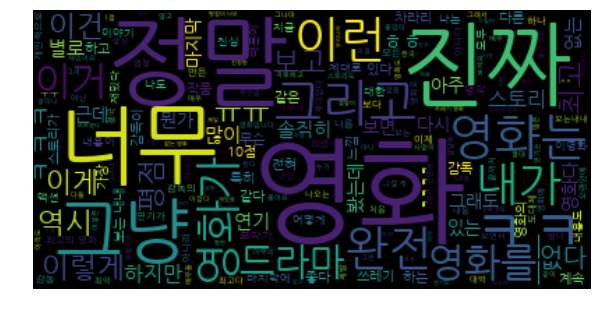

In [11]:
plt.figure(figsize=(10,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

기본 통계를 확인해 봅니다. 

In [12]:
def print_basic_stats(df, col_name):
    print('===== {} ====='.format(col_name))
    print('Maximum: {}'.format(np.max(df[col_name])))
    print('Minimum: {}'.format(np.min(df[col_name])))
    print('Mean: {:.3f}'.format(np.mean(df[col_name])))    
    print('Stddev: {:.3f}'.format(np.std(df[col_name])))
    print('1st quartile: {}'.format(np.percentile(df[col_name], 25)))
    print('Median: {}'.format(np.median(df[col_name])))      
    print('3rd quartile: {}'.format(np.percentile(df[col_name], 75))) 
    
print_basic_stats(train_df, 'char_cnt')
print_basic_stats(train_df, 'word_cnt')    

===== char_cnt =====
Maximum: 146
Minimum: 1
Mean: 35.203
Stddev: 29.532
1st quartile: 16.0
Median: 27.0
3rd quartile: 42.0
===== word_cnt =====
Maximum: 41
Minimum: 1
Mean: 7.585
Stddev: 6.514
1st quartile: 3.0
Median: 6.0
3rd quartile: 9.0


클래스 균형을 확인합니다. 본 데이터는 거의 1:1 비율을 보여주고 있지만, 실제 데이터는 95:5 같은 불균형 데이터들도 많다는 점을 숙지해 주세요.

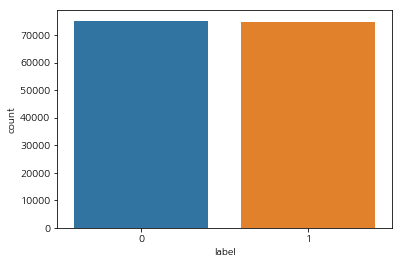

In [13]:
import seaborn as sns
sns.countplot(train_df['label'])

In [14]:
train_df['label'].value_counts()

0    75173
1    74827
Name: label, dtype: int64

## Data Preprocessing

BlazingText 알고리즘으로 분류 문제를 학습하기 위해서는 말뭉치 데이터의 각 문장의 클래스 레이블 앞에 `__label__`을 접두사로 붙여야 합니다. 변환 예시는 아래를 참조해 주세요.

```
__label__0 아 더빙.. 진짜 짜증나네요 목소리
__label__1 흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나
```

또한, 본 노트북에서는 정규식을 활용하여 탭(tab) 문자, 구두점(punctuation) 문자, 한글 문자가 아닌 문자를 제거하는 간단한 전처리를 수행해 보겠습니다.

In [15]:
def preprocess_text(corpus_path, output_path):
    import re
    with open(corpus_path, 'r', encoding='utf-8') as f, \
        open(output_path, 'w', encoding='utf-8') as fw:
        next(f)
        for line in f:
            # Remove tab
            _, sentence, label = line.strip().split('\t') 
            # Remove punctuations
            sentence = re.sub('[\.\,\(\)\{\}\[\]\`\'\!\?\:\;\-\=]', ' ', sentence)
            # Remove non-Korean characters
            sentence = re.sub('[^가-힣ㄱ-하-ㅣ\\s]', '', sentence)
            if not sentence: continue
            fw.writelines('__label__' + label + ' '+ sentence + '\n')    

#### 학습 데이터 전처리 수행

In [16]:
corpus_path = 'data/ratings_train.txt'
output_path = 'data/ratings_train_preprocessd'
preprocess_text(corpus_path, output_path)

In [17]:
!head data/ratings_train_preprocessd -n 5

__label__0 아 더빙   진짜 짜증나네요 목소리
__label__1 흠   포스터보고 초딩영화줄    오버연기조차 가볍지 않구나
__label__0 너무재밓었다그래서보는것을추천한다
__label__0 교도소 이야기구먼   솔직히 재미는 없다  평점 조정
__label__1 사이몬페그의 익살스런 연기가 돋보였던 영화 스파이더맨에서 늙어보이기만 했던 커스틴 던스트가 너무나도 이뻐보였다


#### 검증 데이터 전처리 수행

In [18]:
corpus_path = 'data/ratings_test.txt'
output_path = 'data/ratings_test_preprocessd'
preprocess_text(corpus_path, output_path)

In [19]:
!head data/ratings_test_preprocessd -n 5

__label__1 굳 ㅋ
__label__0 뭐야 이 평점들은     나쁘진 않지만 점 짜리는 더더욱 아니잖아
__label__0 지루하지는 않은데 완전 막장임    돈주고 보기에는    
__label__0 만 아니었어도 별 다섯 개 줬을텐데   왜 로 나와서 제 심기를 불편하게 하죠  
__label__1 음악이 주가 된  최고의 음악영화


#### S3 경로 설정

In [20]:
train_channel = prefix + '/train'
validation_channel = prefix + '/validation'

sess.upload_data(path='data/ratings_train_preprocessd', bucket=bucket, key_prefix=train_channel)
sess.upload_data(path='data/ratings_test_preprocessd', bucket=bucket, key_prefix=validation_channel)

s3_train_data = 's3://{}/{}'.format(bucket, train_channel)
s3_validation_data = 's3://{}/{}'.format(bucket, validation_channel)

모델 아티팩트(Model Artifact)가 저장될 S3의 경로를 설정합니다.

In [21]:
s3_output_location = 's3://{}/{}/output'.format(bucket, prefix)

In [22]:
print(s3_train_data, s3_validation_data, s3_output_location)

s3://blazingtext-hol-daekeun/sagemaker/DEMO-blazingtext-sentiment-analysis/train s3://blazingtext-hol-daekeun/sagemaker/DEMO-blazingtext-sentiment-analysis/validation s3://blazingtext-hol-daekeun/sagemaker/DEMO-blazingtext-sentiment-analysis/output


## Training

이제 학습에 필요한 데이터가 준비되었으므로 `sageMaker.estimator.Estimator` 객체를 생성하여 학습을 수행해 봅니다.

In [23]:
region_name = boto3.Session().region_name
container = sagemaker.amazon.amazon_estimator.get_image_uri(region_name, "blazingtext", "latest")
print('SageMaker BlazingText 컨테이너 위치: {} ({})'.format(container, region_name))

SageMaker BlazingText 컨테이너 위치: 811284229777.dkr.ecr.us-east-1.amazonaws.com/blazingtext:latest (us-east-1)


SageMaker BlazingText는 Word2Vec의 원래 구현과 유사하게 네거티브 샘플링(Negative Sampling)을 사용하여 CPU 및 GPU(들)에서 CBOW(Continuous Bag-of-Words) 및 스킵 그램(Skip-gram) 아키텍처를 효율적으로 구현합니다. GPU 구현은 고도로 최적화된 CUDA 커널을 사용합니다. 자세한 내용은 [*BlazingText: Scaling and Accelerating Word2Vec using Multiple GPUs*](https://dl.acm.org/citation.cfm?doid=3146347.3146354)를 참조하세요. 

또한, BlazingText는 CBOW 및 스킵 그램 모드로 서브 워드(subwords) 임베딩 학습을 지원합니다. 이를 통해 BlazingText는 out-of-vocabulary(OOV)를 생성할 수 있습니다.
서브 워드 임베딩 학습은 [notebook (text8 데이터셋 서브 워드 임베딩)](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/introduction_to_amazon_algorithms/blazingtext_word2vec_subwords_text8/blazingtext_word2vec_subwords_text8.ipynb)을 참조하세요.

스킵 그램 및 CBOW 외에도 SageMaker BlazingText는 효율적인 미니 배치 및 행렬 연산을 수행하는 "배치 스킵 그램(Batch Skipgram)" 모드도 지원합니다. ([BLAS Level 3 routines](https://software.intel.com/en-us/mkl-developer-reference-fortran-blas-level-3-routines)) 이 모드는 여러 CPU 노드에 걸쳐 분산된 Word2Vec의 학습을 가능하게 하여 보다 빠른 학습이 가능합니다. 자세한 내용은 [*Parallelizing Word2Vec in Shared and Distributed Memory*](https://arxiv.org/pdf/1604.04661.pdf)를 참조하세요.

BlazingText는 텍스트 분류를 위한 교사 학습(supervised learning)도 지원하며, 사용자 지정 CUDA 커널을 사용하여 GPU 가속을 활용하도록 FastText 텍스트 분류기를 확장합니다. 이 모델은 최신 딥러닝 텍스트 분류 알고리즘과 동등한 성능을 달성하면서 멀티 코어 CPU 또는 GPU를 사용하여 몇 분 안에 10억 단어 이상을 학습할 수 있습니다. 자세한 내용은 [알고리즘 설명서](https://docs.aws.amazon.com/sagemaker/latest/dg/blazingtext.html)를 참조하세요.


아래 표는 BlazingText에서 지원하는 모드입니다.

|          Modes         	| cbow (서브워드 학습 지원) 	| skipgram (서브워드 학습 지원) | batch_skipgram | supervised |
|:----------------------:	|:----:	|:--------:	|:--------------:| :--------------:|
|   단일 CPU 인스턴스  	|   ✔  	|     ✔    	|        ✔       	|  ✔  |
|   단일 GPU 인스턴스  	|   ✔  	|     ✔    	|              X  	|  ✔ (1 GPU 인스턴스만 지원)  |
| 다중 CPU 인스턴스 	|   X 	|     X     	|        ✔       	 |  X    |

In [24]:
bt_model = sagemaker.estimator.Estimator(container,
                                         role, 
                                         train_instance_count=1, 
                                         train_instance_type='ml.c4.2xlarge',
                                         train_volume_size=30,
                                         train_max_run=360000,
                                         input_mode='File',
                                         output_path=s3_output_location,
                                         sagemaker_session=sess)

BlazingText 하이퍼파라메터의 자세한 설정 방법은 [이 문서](https://docs.aws.amazon.com/sagemaker/latest/dg/blazingtext_hyperparameters.html)를 참조해 주세요.

In [25]:
bt_model.set_hyperparameters(mode="supervised",
                            epochs=30,
                            min_count=2,
                            learning_rate=0.005,
                            vector_dim=100,
                            early_stopping=True,
                            patience=4,  # Number of epochs to wait before early stopping if no progress on the validation set is observed
                            buckets=2000000, # Number of hash buckets to use for word n-grams
                            min_epochs=5,
                            word_ngrams=2)

학습을 위한 `sagemaker.session.s3_input` 객체를 생성하여 데이터 채널을 알고리즘과 연결합니다.

In [26]:
train_data = sagemaker.session.s3_input(s3_train_data, distribution='FullyReplicated', 
                        content_type='text/plain', s3_data_type='S3Prefix')
validation_data = sagemaker.session.s3_input(s3_validation_data, distribution='FullyReplicated', 
                        content_type='text/plain', s3_data_type='S3Prefix')
data_channels = {'train': train_data, 'validation': validation_data}

지금까지 `Estimator` 객체에 대한 하이퍼파라미터를 설정했으며 데이터 채널을 알고리즘과 연결했습니다. 남은 것은 `fit` 메소드로 학습하는 것뿐입니다.<br>
학습에는 몇 가지 단계가 포함됩니다. 먼저 `Estimator` 클래스를 작성하는 동안 요청한 인스턴스가 프로비저닝되고 적절한 라이브러리로 설정됩니다. 그 다음 채널의 데이터가 학습 인스턴스로 다로드되며 이후 학습 작업이 시작됩니다. 데이터 크기에 따라 프로비저닝 및 데이터 다운로드에 시간이 다소 걸리며, 이에 따라 학습 작업에 따른 로그를 확인하는 데 몇 분이 걸립니다.

로그는 `min_epochs`(이 파라메터는 학습에 최소로 필요한 epoch 횟수입니다) 이후 모든 epoch에 대한 검증 데이터의 정확도(accuracy)를 출력합니다.

학습이 완료되면 "작업 완료(Job compelete)" 메시지가 출력됩니다. 학습된 모델은 `Estimator`에서 `output_path`로 설정된 S3 버킷에서 찾을 수 있습니다.

In [27]:
bt_model.fit(inputs=data_channels, logs=True)

2019-11-05 22:52:16 Starting - Starting the training job...
2019-11-05 22:52:34 Starting - Launching requested ML instances.........
2019-11-05 22:54:06 Starting - Preparing the instances for training...
2019-11-05 22:54:40 Downloading - Downloading input data...
2019-11-05 22:55:14 Training - Training image download completed. Training in progress..Arguments: train
[11/05/2019 22:55:15 WARNING 140218781001536] Loggers have already been setup.
[11/05/2019 22:55:15 WARNING 140218781001536] Loggers have already been setup.
[11/05/2019 22:55:15 INFO 140218781001536] nvidia-smi took: 0.025171995163 secs to identify 0 gpus
[11/05/2019 22:55:15 INFO 140218781001536] Running single machine CPU BlazingText training using supervised mode.
[11/05/2019 22:55:15 INFO 140218781001536] Processing /opt/ml/input/data/train/ratings_train_preprocessd . File size: 13 MB
[11/05/2019 22:55:15 INFO 140218781001536] Processing /opt/ml/input/data/validation/ratings_test_preprocessd . File size: 4 MB
Read 1M w

#### Tip
데이터셋이 잘 정제되어 있어 전처리를 거의 수행하지 않았음에도 검증셋에서 비교적 높은 정확도(accuracy)를 보입니다.
이를 baseline으로 잡고 불용어(stopword) 제거, 형태소 분석 등의 전처리와 하이퍼파라메터 튜닝을 통해 
좀 더 높은 정확도를 달성할 수 있습니다. 특히, 한국어 데이터의 다운스트림 작업들은 하이퍼파라메터 튜닝보다는 전처리가 훨씬 중요하니 이 점을 유의해 주세요.

## Hosting / Inference
학습을 완료하면 모델을 Amazon SageMaker 실시간 호스팅 엔드포인트(real-time hosted endpoint)로 배포할 수 있고, 이를 통해 모델로부터 추론(inference)을 수행합니다. (추론은 예측; prediction 이라고도 합니다.) 실시간 추론 수행 시 엔드포인트는 계속 가동되어야 하므로, 추론을 위해 저렴한 인스턴스를 선택하시는 것을 권장합니다.

이 과정은 약 10분 정도 소요됩니다.

In [28]:
text_classifier = bt_model.deploy(initial_instance_count = 1,instance_type = 'ml.m4.xlarge')

----------------------------------------------------------------------------------------------------------!

#### Use JSON format for inference

BlazingText는 추론을 위한 컨텐츠 유형(content-type)으로 `application/json` 을 지원합니다. 엔드포인트로 전달할 입력 문장은 "**instances**" 키가 반드시 포함되어야 합니다.

In [29]:
import nltk
nltk.download('punkt')
sentences = ["재미있게 봤습니다. 제 점수는요 100점 만점에 80점 드리겠습니다.",
            "스토리가 너무 단방향이라 재미가 없고 성우 더빙도 그닥이네요..."]

tokenized_sentences = [' '.join(nltk.word_tokenize(sent)) for sent in sentences]
payload = {"instances" : tokenized_sentences}

response = text_classifier.predict(json.dumps(payload))

predictions = json.loads(response)
print(json.dumps(predictions, indent=2))

[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[
  {
    "prob": [
      0.9286458492279053
    ],
    "label": [
      "__label__1"
    ]
  },
  {
    "prob": [
      0.9930349588394165
    ],
    "label": [
      "__label__0"
    ]
  }
]



기본적으로는 확률이 가장 높은 예측 결과(top-1 prediction)만 반환합니다. 상위 k개의 예측(top-k prediction)을 얻으려면 `configuration` key에서 `k`를 지정하면 됩니다. 아래 code snippet을 참조해 주세요.

```python
payload = {"instances" : tokenized_sentences,
          "configuration": {"k": 2}}

response = text_classifier.predict(json.dumps(payload))

predictions = json.loads(response)
print(json.dumps(predictions, indent=2))
```

## Stop / Close the Endpoint (Optional)
실시간 예측을 제공하기 위해 엔드포인트를 계속 실행할 필요가 없는 경우, 과금을 막기 위해 엔드포인트를 삭제합니다.

In [30]:
sess.delete_endpoint(text_classifier.endpoint)